# Country Borders with Walls

Using data from Figure 1 of *Barriers to Entry: Who Builds Fortifed Boundaries and Why?* by Ron E. Hassner and Jason Wittenberg

You can download the PDF for free here: https://www.mitpressjournals.org/doi/pdf/10.1162/ISEC_a_00206

I used [tabula](http://tabula.technology/) to extract the table from the pdf and copied them to this [google sheet](https://docs.google.com/spreadsheets/d/1aAIu_sgL39S5Wd-eH29JqI73vxrlPWqruzn38UMQ9XI/edit#gid=0).

In [1]:
import pandas as pd

In [2]:
# Copy table from https://docs.google.com/spreadsheets/d/1aAIu_sgL39S5Wd-eH29JqI73vxrlPWqruzn38UMQ9XI/edit#gid=0
df = pd.read_clipboard()

In [3]:
df

,Builder-Target,Start Date,Approximate Length (miles),Stated Target,Confidence in Start Date
0,Soviet Union (East Germany)-West Germany (inne...,1952,845,fascism,high
1,France (Algeria)-Tunisia,1957,171,insurgents,high
2,Soviet Union (East Germany)-West Germany (Berl...,1961,93,fascism,high
3,Israel-Lebanon,1975?,NaN,NaN,low
4,South Africa-Mozambique,1976,NaN,NaN,moderate
5,Soviet Union-Norway,1976?,NaN,NaN,very low
6,Soviet Union-Finland,1978?,NaN,NaN,very low
7,South Africa-Zimbabwe,1979–83?,114,NaN,low
8,Morocco-Western Sahara,1980,"1,020?",militants,high
9,Israel-Jordan,1981?,NaN,NaN,low


# Create a network to represent builder -> target relationships

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
%matplotlib inline

In [5]:
# Create separate source and target columns
df['Source'] = df['Builder-Target'].apply(lambda x: x.split("-")[0])
df['Target'] = df['Builder-Target'].apply(lambda x: x.split("-")[1])

In [6]:
df.head()

,Builder-Target,Start Date,Approximate Length (miles),Stated Target,Confidence in Start Date,Source,Target
0,Soviet Union (East Germany)-West Germany (inne...,1952,845,fascism,high,Soviet Union (East Germany),West Germany (inner German border)
1,France (Algeria)-Tunisia,1957,171,insurgents,high,France (Algeria),Tunisia
2,Soviet Union (East Germany)-West Germany (Berl...,1961,93,fascism,high,Soviet Union (East Germany),West Germany (Berlin Wall)
3,Israel-Lebanon,1975?,NaN,NaN,low,Israel,Lebanon
4,South Africa-Mozambique,1976,NaN,NaN,moderate,South Africa,Mozambique


Get a list of unique nodes (i.e countries):

In [7]:
nodes = list(np.unique(df['Source'].values)) + list(np.unique(df['Target'].values))

Get a list of edges (i.e. builder -> target relationships):

In [8]:
edges = zip(df['Source'].values, df['Target'].values)

In [9]:
def make_graph(nodes, edges):
    g = nx.DiGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    print len(g.nodes()), "nodes"
    print len(g.edges()), "edges"
    return g

In [10]:
G = make_graph(nodes, edges)

55 nodes
48 edges


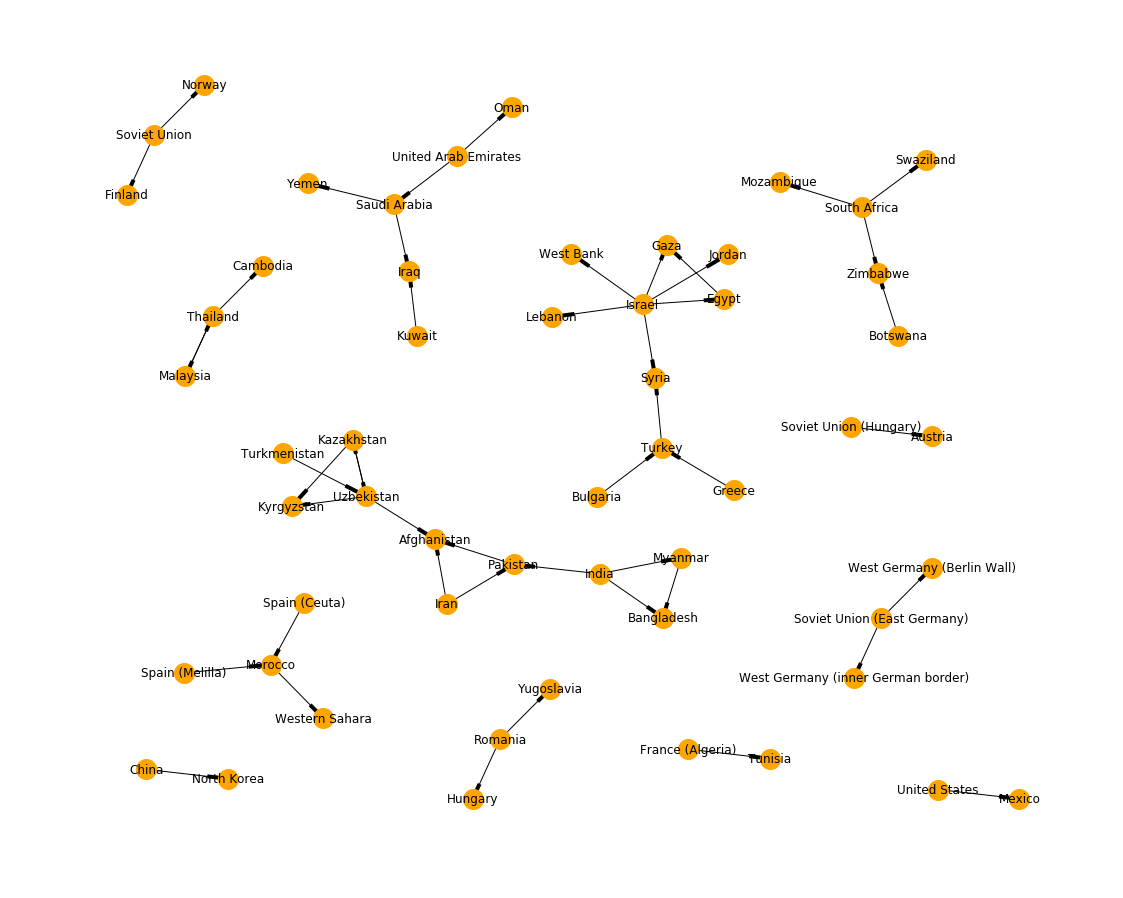

In [11]:
pos = graphviz_layout(G)
plt.figure(figsize=(15,12)) 
nx.draw(G, pos, with_labels = True, node_size=400, font_size=12, node_color='orange', arrows=True)

# Get country border polygons

Country borders from: http://www.naturalearthdata.com/downloads/10m-cultural-vectors/

In [12]:
import geopandas as gpd

In [13]:
countries = gpd.read_file("ne_10m_admin_0_countries.geojson")

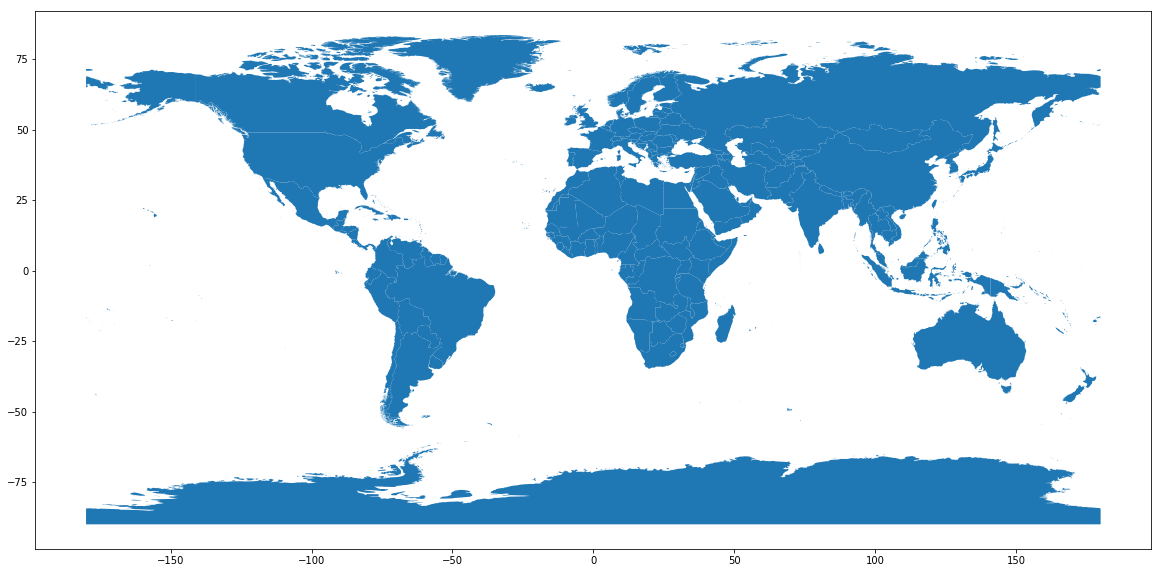

In [14]:
countries.plot(figsize=(20,10));

# Associate every country name in the border walls dataset with a polygon

In [15]:
natural_earth_country_names = list(countries['SOVEREIGNT'])
country_borders = {}
failures = []

for country in nodes:
    if country in natural_earth_country_names:
        row = countries[countries['SOVEREIGNT'] == country]
        geometry = row['geometry']
        country_borders[country] = gpd.GeoDataFrame(geometry)
    else:
        # Manually adjust country names where known mismatch
        if country == "United States":
            row = countries[countries['SOVEREIGNT'] == "United States of America"]
            geometry = row['geometry']
            country_borders[country] = gpd.GeoDataFrame(geometry)
        else:
            failures.append(country)
            
print "Successes:"
print country_borders.keys()
print ""
print "Failures:"
print failures

Successes:
['Turkey', 'Afghanistan', 'Turkmenistan', 'Kuwait', 'Cambodia', 'Swaziland', 'Norway', 'Bangladesh', 'Israel', 'Iran', 'Jordan', 'Zimbabwe', 'China', 'Lebanon', 'Thailand', 'Iraq', 'Kazakhstan', 'Kyrgyzstan', 'Western Sahara', 'Oman', 'Finland', 'Saudi Arabia', 'United States', 'Morocco', 'Syria', 'Yemen', 'Bulgaria', 'Pakistan', 'Romania', 'North Korea', 'Myanmar', 'South Africa', 'Egypt', 'United Arab Emirates', 'Mexico', 'India', 'Uzbekistan', 'Malaysia', 'Austria', 'Mozambique', 'Tunisia', 'Greece', 'Hungary', 'Botswana']

Failures:
['France (Algeria)', 'Soviet Union', 'Soviet Union (East Germany)', 'Soviet Union (Hungary)', 'Spain (Ceuta)', 'Spain (Melilla)', 'Gaza', 'West Bank', 'West Germany (Berlin Wall)', 'West Germany (inner German border)', 'Yugoslavia']


Will need to manually draw borders for those failures.

# Get shared borders between countries with known border walls

The logic here is to cycle through every edge in the border wall network, get the polygons for the builder and target countries, use GeoPandas to check for an intersection between builder and target country polygons and add it to a list.

In [16]:
def get_shared_borders(G, country_borders):
    results = []

    # for every edge in the network
    for edge in G.edges():

        # get source and target names
        source = edge[0]
        target = edge[1]

        try:
            # get source and target polygons
            source_polygon = country_borders[source]
            target_polygon = country_borders[target]

            # look for intersections
            for i in source_polygon.index:
                for j in target_polygon.index:

                    A = gpd.GeoDataFrame(source_polygon.loc[i])
                    B = gpd.GeoDataFrame(target_polygon.loc[j])

                    A.columns=['geometry']
                    B.columns=['geometry']

                    # if there is a shared border add it to the list
                    if A.intersects(B)['geometry']:
                        intersection = A.intersection(B)
                        intersection = gpd.GeoDataFrame(intersection)
                        intersection.columns = ['geometry']
                        intersection['Source'] = source
                        intersection['Target'] = target
                        results.append(intersection)
        except:
            pass
        
    output = pd.concat(results)
    output = output.reset_index(drop=True)
    return output

In [17]:
shared_borders = get_shared_borders(G, country_borders)

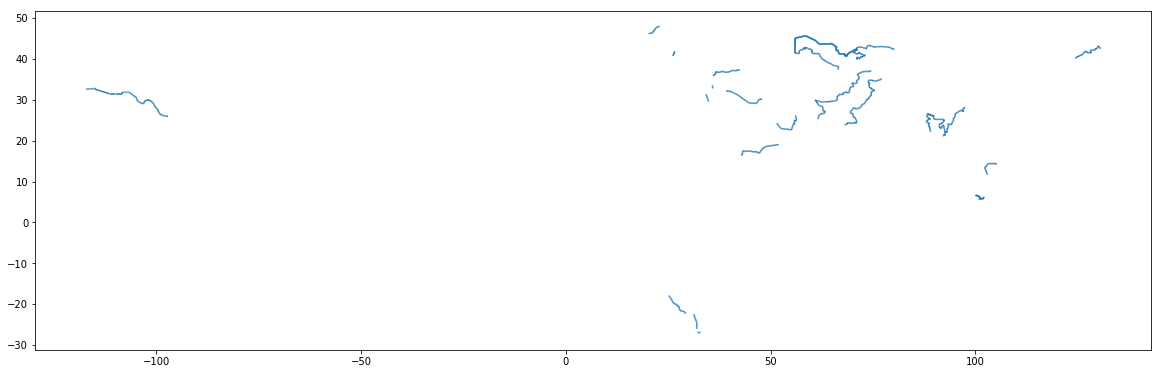

In [18]:
shared_borders.plot(figsize=(20,10));

# Write the shared border geometries to a GeoJSON

In [19]:
import geojson
from geojson import Feature, FeatureCollection

In [20]:
def shared_borders_to_geojson(shared_borders, outfile=False):
    features = []

    for i in shared_borders.index:
        row = shared_borders.loc[[i]]
        source = str(row['Source'])
        target = str(row['Target'])
        geometry = row['geometry']
        for j in geometry:    
            for geom in list(j):
                feature = Feature(geometry=geom)
                feature['properties']['Source'] = source
                feature['properties']['Target'] = target
                features.append(feature)
    feature_collection = FeatureCollection(features)
    
    if outfile:
        with open(outfile, 'a') as f:
            geojson.dump(feature_collection, f)
    
    return feature_collection

In [21]:
shared_borders_geojson = shared_borders_to_geojson(shared_borders, 
                                                   outfile="country_borders_with_walls.geojson")

# Need to manually draw shared borders for some of the countries

The following places do not exist in the natural earth dataset (some for obvious reasons), so we need to get their polygons some other way:

- France (Algeria)
- Soviet Union
- Soviet Union (East Germany)
- Soviet Union (Hungary)
- Spain (Ceuta)
- Spain (Melilla)
- Gaza
- West Bank
- West Germany (Berlin Wall)
- West Germany (inner German border)
- Yugoslavia